In [ ]:
!pip install nltk

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 1.4 MB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 284 kB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 2.4 MB/s eta 0:00:01
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434676 sha256=30cb50fad61ae5e337aa3a70e20c61e822351b60308a71197ba91e7fd8d443bb
  Stored in directory: /Users/niloofar/Library/Caches/pip/wheels/ff/d5/7b/f1fb4e1e1603b2f01c2424dd60fbcc50c12ef918bafc44b155
Successfully built nltk
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-scrip

In [ ]:
conda install -c conda-forge wordcloud

Solving environment: done

## Package Plan ##

  environment location: /Users/niloofar/opt/anaconda3

  added / updated specs:
    - wordcloud


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.0               |   py37hf985489_0         3.0 MB  conda-forge
    matplotlib-base-3.1.0      |   py37h3a684a6_1         6.6 MB  conda-forge
    wordcloud-1.8.1            |   py37hf967b71_1         169 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         9.8 MB

The following NEW packages will be INSTALLED:

  matplotlib-base    conda-forge/osx-64::matplotlib-base-3.1.0-py37h3a684a6_1
  wordcloud          conda-forge/osx-64::wordcloud-1.8.1-py37hf967b71_1

The following packages will be UPDATED:

  conda                                4.9.2-py37hf985489_0 --> 4.10.0-py37hf985489_0



wordcloud-1.8.1   

In [ ]:
!pip install keras

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.9 MB 2.1 MB/s eta 0:00:01
     |████████████████████████████████| 253 kB 2.4 MB/s eta 0:00:01
     |████████████████████████████████| 30.8 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 16.0 MB 730 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import keras
from keras.models import Sequential
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.utils import np_utils
from keras import optimizers
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk import TweetTokenizer
from keras.layers import Embedding, Masking, Bidirectional
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
import tensorflow

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
import seaborn as sns
sns.set_style('darkgrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [5]:
tweets = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding='ISO-8859-1',
                      header=None)

# Change the columns' name
tweets.columns = ['target','id','date','flag','user','text']

# Change label '4' to '1'
tweets.target = tweets.target.map({4:1,0:0})

In [6]:
def format_text(df,col):
  #Remove @ tags
  comp_df = df.copy()
    
  # remove all the punctuation
  comp_df[col] = comp_df[col].str.replace(r'(@\w*)','')

  #Remove URL
  comp_df[col] = comp_df[col].str.replace(r"http\S+", "")

  #Remove # tag and the following words
  comp_df[col] = comp_df[col].str.replace(r'#\w+',"")

  #Remove all non-character
  comp_df[col] = comp_df[col].str.replace(r"[^a-zA-Z ]","")

  # Remove extra space
  comp_df[col] = comp_df[col].str.replace(r'( +)'," ")
  comp_df[col] = comp_df[col].str.strip()

  # Change to lowercase
  comp_df[col] = comp_df[col].str.lower()

  return comp_df

formated_tweets = format_text(tweets,'text')

# Drop the columns we don't want
formated_tweets.drop(['id','date','flag','user'],axis=1,inplace=True)

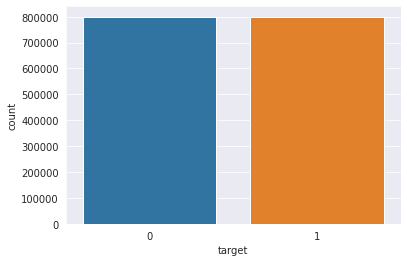

In [ ]:
#show the distribution of labels
sns.countplot(tweets.target)
plt.show()

In [ ]:
formated_tweets.head()

,target,text
0,0,awww thats a bummer you shoulda got david carr...
1,0,is upset that he cant update his facebook by t...
2,0,i dived many times for the ball managed to sav...
3,0,my whole body feels itchy and like its on fire
4,0,no its not behaving at all im mad why am i her...


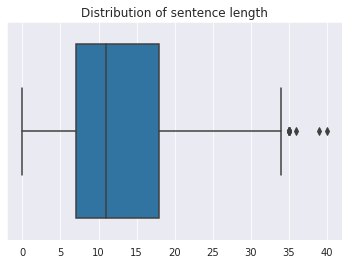

In [ ]:
sen_length = [len(x) for x in formated_tweets.text.tolist()]
sns.boxplot(sen_length)
plt.title('Distribution of sentence length')
plt.show()

In [7]:
tweet_tokenizer= TweetTokenizer(reduce_len=3)
formated_tweets.text = formated_tweets.text.apply(lambda x: tweet_tokenizer.tokenize(x))

In [8]:
# Function for build text list
def word_list(dataframe,clear_stopwords=False):
  df = dataframe.copy()
    
  # lemmatize the word
  lemma = nltk.WordNetLemmatizer()
  df.text = df.text.apply(lambda x: [lemma.lemmatize(i) for i in x])
  if clear_stopwords:
    stop_words = stopwords.words('english')
    df.text = df.text.apply(lambda x: [i for i in x if not i in stop_words])
    
  # combined into a sentence again
  df.text = df.text.apply(lambda x: ' '.join(x))

  word_list = df.text.tolist()
  return word_list

# Tokenize and padding the text list
def token_padding(word_list, tokenizer,length,pad):
  sequences = tokenizer.texts_to_sequences(word_list)
  padding = pad_sequences(sequences, maxlen=length,padding=pad,truncating='post')
  return padding

In [9]:
embedding_dim = 100 # since we will use 100d of Glove
max_length = 30
padding = 'post'
oov_tok = '<OOV>'
batch_size = 256
training_size = formated_tweets.shape[0]
print(training_size)
test_size = 0.2 * formated_tweets.shape[0] #number of samples for testing, not percentage
stop_words_clear = False

cropped_df = formated_tweets.sample(training_size) #get the sample randomly from the original dataset

# Split the data into training and validation(test) set
x_train,x_val,y_train,y_val = train_test_split(cropped_df.drop('target',axis=1),cropped_df['target'],test_size=round(test_size/training_size,2))
x_train_list = word_list(x_train,clear_stopwords=stop_words_clear)
x_val_list = word_list(x_val,clear_stopwords=stop_words_clear)

# make tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_list)

x_train_pad = token_padding(x_train_list,tokenizer,max_length,padding)
x_val_pad = token_padding(x_val_list,tokenizer,max_length,padding)

train_set = tensorflow.data.Dataset.from_tensor_slices((x_train_pad,np.array(y_train))).batch(batch_size)
test_set = tensorflow.data.Dataset.from_tensor_slices((x_val_pad,np.array(y_val))).batch(batch_size)

1600000


In [ ]:
print(y_train.shape)
print(np.array(x_train_list).shape)
print(y_val.shape)
print(np.array(x_val_list).shape)
print(test_set)
print(train_set)

(1280000,)
(1280000,)
(320000,)
(320000,)
<BatchDataset shapes: ((None, 30), (None,)), types: (tf.int32, tf.int64)>
<BatchDataset shapes: ((None, 30), (None,)), types: (tf.int32, tf.int64)>


In [10]:
word_index = tokenizer.word_index
vocab_size = len(word_index)+1
embeddings_index = {};

# Word embeddings with Glove6B 100D
# Add the glove6b 100D to the input data of kaggle before use it
with  open('glove.6B.100d.txt','r') as file:
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = vector
        
# Build embedding matrix 
embeddings_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        embeddings_matrix[i] = vector

In [11]:
import keras.backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [11]:
lstmModel = Sequential()
lstmModel.add(Embedding(input_dim=vocab_size,
                    mask_zero=True, output_dim=100, input_length=30, weights=[embeddings_matrix], trainable=False))
lstmModel.add(Bidirectional(LSTM(64, dropout = 0.25, return_sequences=True)))
lstmModel.add(Bidirectional(LSTM(64,dropout=0.25)))
lstmModel.add(Dense(512,activation='relu'))
lstmModel.add(Dense(1,activation='sigmoid'))
#lstmModel.add(Dense(1,activation = 'softmax'))
      
lstmModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])


#callbacks = myCallback()

results_LSTM = lstmModel.fit(train_set, epochs=10, validation_data=(test_set),verbose=1)
lstmModel.save('/content/gdrive/My Drive//lstmModel-new.pt')

Epoch 1/10
5000/5000 [==============================] - 631s 123ms/step - loss: 0.5176 - acc: 0.7386 - f1_m: 0.7350 - precision_m: 0.7465 - recall_m: 0.7322 - val_loss: 0.4307 - val_acc: 0.7992 - val_f1_m: 0.7957 - val_precision_m: 0.8076 - val_recall_m: 0.7855
Epoch 2/10
5000/5000 [==============================] - 586s 117ms/step - loss: 0.4424 - acc: 0.7917 - f1_m: 0.7907 - precision_m: 0.7946 - recall_m: 0.7894 - val_loss: 0.4116 - val_acc: 0.8102 - val_f1_m: 0.8120 - val_precision_m: 0.8027 - val_recall_m: 0.8228
Epoch 3/10
5000/5000 [==============================] - 582s 116ms/step - loss: 0.4245 - acc: 0.8024 - f1_m: 0.8018 - precision_m: 0.8044 - recall_m: 0.8012 - val_loss: 0.4020 - val_acc: 0.8162 - val_f1_m: 0.8175 - val_precision_m: 0.8096 - val_recall_m: 0.8267
Epoch 4/10
5000/5000 [==============================] - 585s 117ms/step - loss: 0.4149 - acc: 0.8076 - f1_m: 0.8067 - precision_m: 0.8098 - recall_m: 0.8054 - val_loss: 0.3962 - val_acc: 0.8195 - val_f1_m: 0.8205 -

NameError: ignored

In [16]:
# lOSS, ACCURACY, F1-SCORE, PRECISION, RECALL
evaluate = lstmModel.evaluate(x_val_pad, y_val, verbose=0)
print(evaluate)

[0.383465439081192, 0.8264718651771545, 0.824509859085083, 0.8167005777359009, 0.8417314291000366]


In [ ]:
lstmModel.save('/content/gdrive/My Drive//lstmModel.pt')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive//lstmModel.pt/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive//lstmModel.pt/assets


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
RNNModel = Sequential()
RNNModel.add(Embedding(input_dim=vocab_size,
                    mask_zero=True, output_dim=100, input_length=30, weights=[embeddings_matrix], trainable=False))
RNNModel.add(Bidirectional(SimpleRNN(64, dropout = 0.25, return_sequences=True)))
RNNModel.add(Bidirectional(SimpleRNN(64,dropout=0.25)))
RNNModel.add(Dense(512,activation='relu'))
RNNModel.add(Dense(1,activation='sigmoid'))
#lstmModel.add(Dense(1,activation = 'softmax'))
      
RNNModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])

#callbacks = myCallback()

results_RNN = RNNModel.fit(train_set, epochs=10, validation_data=(test_set),verbose=1)
# lOSS, ACCURACY, F1-SCORE, PRECISION, RECALL
evaluate2 = RNNModel.evaluate(x_val_pad, y_val, verbose=0)
RNNModel.save('/content/gdrive/My Drive//rnnModel.pt')

Epoch 1/10
5000/5000 [==============================] - 913s 182ms/step - loss: 0.5587 - acc: 0.7064 - f1_m: 0.6999 - precision_m: 0.7155 - recall_m: 0.6931 - val_loss: 0.4669 - val_acc: 0.7773 - val_f1_m: 0.7760 - val_precision_m: 0.7792 - val_recall_m: 0.7742
Epoch 2/10
5000/5000 [==============================] - 927s 185ms/step - loss: 0.4857 - acc: 0.7645 - f1_m: 0.7627 - precision_m: 0.7682 - recall_m: 0.7615 - val_loss: 0.4469 - val_acc: 0.7890 - val_f1_m: 0.7854 - val_precision_m: 0.7971 - val_recall_m: 0.7755
Epoch 3/10
5000/5000 [==============================] - 890s 178ms/step - loss: 0.4696 - acc: 0.7756 - f1_m: 0.7742 - precision_m: 0.7785 - recall_m: 0.7735 - val_loss: 0.4432 - val_acc: 0.7942 - val_f1_m: 0.7970 - val_precision_m: 0.7848 - val_recall_m: 0.8108
Epoch 4/10
5000/5000 [==============================] - 878s 176ms/step - loss: 0.4613 - acc: 0.7807 - f1_m: 0.7794 - precision_m: 0.7834 - recall_m: 0.7788 - val_loss: 0.4340 - val_acc: 0.7981 - val_f1_m: 0.7943 -

INFO:tensorflow:Assets written to: /content/gdrive/My Drive//rnnModel.pt/assets


In [ ]:
print(evaluate2)

[0.4265221059322357, 0.8038656115531921, 0.7989364862442017, 0.8031806349754333, 0.8048858046531677]


In [12]:
GRUModel = Sequential()
GRUModel.add(Embedding(input_dim=vocab_size,
                    mask_zero=True, output_dim=100, input_length=30, weights=[embeddings_matrix], trainable=False))
GRUModel.add(Bidirectional(GRU(64, dropout = 0.25, return_sequences=True)))
GRUModel.add(Bidirectional(GRU(64,dropout=0.25)))
GRUModel.add(Dense(512,activation='relu'))
GRUModel.add(Dense(1,activation='sigmoid'))
#lstmModel.add(Dense(1,activation = 'softmax'))
      
GRUModel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', f1_m, precision_m, recall_m])

#callbacks = myCallback()

results_GRU = GRUModel.fit(train_set, epochs=10, validation_data=(test_set),verbose=1)
# lOSS, ACCURACY, F1-SCORE, PRECISION, RECALL
evaluate3 = GRUModel.evaluate(x_val_pad, y_val, verbose=0)
GRUModel.save('/content/gdrive/My Drive//gruModel.pt')
print(evaluate3)

Epoch 1/10
5000/5000 [==============================] - 739s 139ms/step - loss: 0.5146 - acc: 0.7408 - f1_m: 0.7347 - precision_m: 0.7483 - recall_m: 0.7304 - val_loss: 0.4338 - val_acc: 0.7981 - val_f1_m: 0.7889 - val_precision_m: 0.8229 - val_recall_m: 0.7589
Epoch 2/10
5000/5000 [==============================] - 688s 138ms/step - loss: 0.4437 - acc: 0.7915 - f1_m: 0.7900 - precision_m: 0.7933 - recall_m: 0.7890 - val_loss: 0.4130 - val_acc: 0.8098 - val_f1_m: 0.8082 - val_precision_m: 0.8116 - val_recall_m: 0.8061
Epoch 3/10
5000/5000 [==============================] - 691s 138ms/step - loss: 0.4282 - acc: 0.8005 - f1_m: 0.7991 - precision_m: 0.8021 - recall_m: 0.7981 - val_loss: 0.4052 - val_acc: 0.8142 - val_f1_m: 0.8146 - val_precision_m: 0.8101 - val_recall_m: 0.8202
Epoch 4/10
5000/5000 [==============================] - 700s 140ms/step - loss: 0.4202 - acc: 0.8057 - f1_m: 0.8046 - precision_m: 0.8065 - recall_m: 0.8044 - val_loss: 0.4012 - val_acc: 0.8172 - val_f1_m: 0.8152 -

INFO:tensorflow:Assets written to: /content/gdrive/My Drive//gruModel.pt/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive//gruModel.pt/assets


[0.39621102809906006, 0.821274995803833, 0.8132791519165039, 0.832452654838562, 0.8046557903289795]


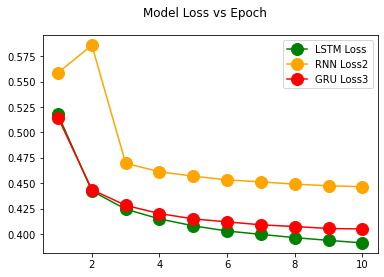

In [15]:
# Plotting loss vs Epoch:
import matplotlib.pyplot as plt
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
loss = [0.5176, 0.4424, 0.4245, 0.4149, 0.4081, 0.4030, 0.3997, 0.3965, 0.3938, 0.3913]
loss2 = [0.5587, 0.5857, 0.4696, 0.4613, 0.4569, 0.4533, 0.4513, 0.4491, 0.4475, 0.4466]
loss3 = [0.5146, 0.4437, 0.4282, 0.4202, 0.4149, 0.4120, 0.4091, 0.4074, 0.4055, 0.4050]

fig1, ax  = plt.subplots()
fig1.suptitle('Model Loss vs Epoch')
ax.plot(epochs,loss, marker='o', linestyle='-', ms=12, color="green", label="LSTM Loss")
ax.legend()
ax.plot(epochs,loss2, marker='o', linestyle='-', ms=12, color="orange", label="RNN Loss2")
ax.legend()
ax.plot(epochs,loss3, marker='o', linestyle='-', ms=12, color="red", label="GRU Loss3")
ax.legend()




/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


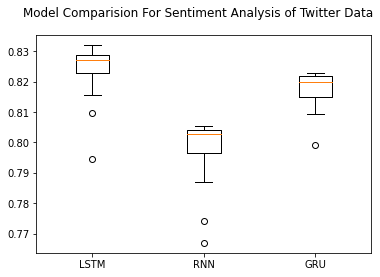

In [ ]:
#Comparing the performance of the above 4 algorithms with 20 epochs for LSTM, and RNN. 12 Epochs for GRU.
import matplotlib.pyplot as plt
score = [0.7945, 0.8096, 0.8156, 0.8196,0.8211, 0.8234, 0.8244, 0.8257, 0.8263, 0.8273, 0.8273, 0.8282, 0.8284, 0.8286, 0.8286, 0.8290, 0.8295, 0.8294, 0.8300, 0.8320 ]
score2 = [0.7669, 0.7740, 0.7904, 0.7869, 0.7969, 0.7950, 0.8030, 0.8014, 0.8032, 0.8045, 0.8041, 0.8050, 0.8035, 0.8049, 0.8033, 0.8026, 0.8039, 0.8026, 0.7993, 0.8053]
score3 = [0.7990, 0.8094, 0.8123, 0.8158, 0.8182, 0.8195, 0.8203, 0.8208, 0.8217, 0.8226, 0.8228, 0.8225]
fig = plt.figure()
fig.suptitle("Model Comparision For Sentiment Analysis of Twitter Data")
ax = fig.add_subplot(111)
plt.boxplot([score, score2, score3])
ax.set_xticklabels(["LSTM","RNN", "GRU"])
plt.show()

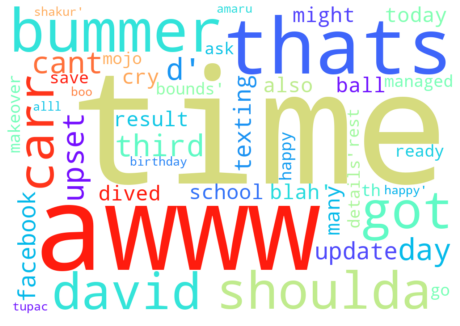

In [ ]:
def show_wc(tweets,stopword=False):
    if stopword:
        stop_words = stopwords.words('english')
        wc = WordCloud(max_words=1000, background_color='white',stopwords=stop_words,colormap='rainbow',height=700,width=1000)
    else:
        wc = WordCloud(max_words=1000, background_color='white',colormap='rainbow',height=700,width=1000)
    text =tweets.text.values
    wc.generate(str(text))
    
    fig = plt.figure()
    plt.imshow(wc)
    fig.set_figwidth(8)
    fig.set_figheight(12)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()
show_wc(formated_tweets, stopword=True)